In [2]:
import pandas as pd
import math
import numpy as np
import scipy.io as sio
from sklearn import svm, metrics, cross_validation
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yikaluo/applications/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Data Partitioning

In [3]:
## MNIST
mnist_df = sio.loadmat("./hw01_data/mnist/train.mat")['trainX']
np.random.shuffle(mnist_df)
mnist_validate = mnist_df[:10000, :]
mnist_train = mnist_df[10000:, :]

In [4]:
## cifar
cifar_df = sio.loadmat("./hw01_data/cifar/train.mat")['trainX']
np.random.shuffle(cifar_df)
cifar_validate = cifar_df[:5000, :]
cifar_train = cifar_df[5000:, :]

In [5]:
## Spam
spam_train_data = sio.loadmat("./hw01_data/spam/spam_data.mat")['training_data']
spam_train_label = sio.loadmat("./hw01_data/spam/spam_data.mat")['training_labels']
spam_train_label = spam_train_label.reshape((len(spam_train_data), 1))
spam_df = np.concatenate((spam_train_data, spam_train_label), axis = 1)
np.random.shuffle(spam_df)
spam_validate = spam_df[:int((len(spam_df) * 0.2)), :]
spam_train = spam_df[(int(len(spam_df) * 0.2)):, :]

# 2. Support Vector Machines

In [11]:
def train_and_error(train_data, validate_data, categories):
    
    errors, v_errors = [], []
    x = train_data[:, :-1]
    y = train_data[:, -1:].reshape(1, len(x))[0]
    v_x = validate_data[:, :-1]
    v_y = validate_data[:, -1:].reshape(1, len(v_x))[0]
    
    for size in categories:
        clf = svm.SVC(kernel = "linear")
        x_fit = x[:size, :]
        y_fit = y[:size]
        clf.fit(x_fit, y_fit)
        v_y_hat = clf.predict(v_x)
        y_hat = clf.predict(x_fit)
        # Error rate
        err = 1 - metrics.accuracy_score(y_fit, y_hat)
        v_err = 1 - metrics.accuracy_score(v_y, v_y_hat)
        errors.append(err)
        v_errors.append(v_err)
    
    plt.plot(categories, errors, 'ro', label = "training")
    plt.plot(categories, v_errors, 'go', label = "validate")
    plt.axis([min(categories)-10, max(categories)+10, -0.1, max(v_errors)+0.1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("CIFAR Error rate")


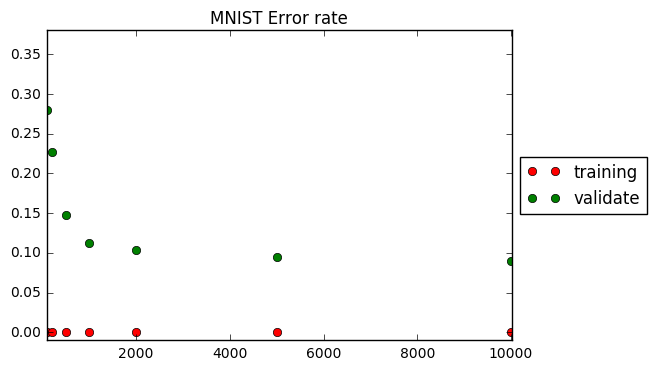

In [8]:
## MNIST
categories = [100, 200, 500, 1000, 2000, 5000, 10000]
train_and_error(mnist_train, mnist_validate, categories)

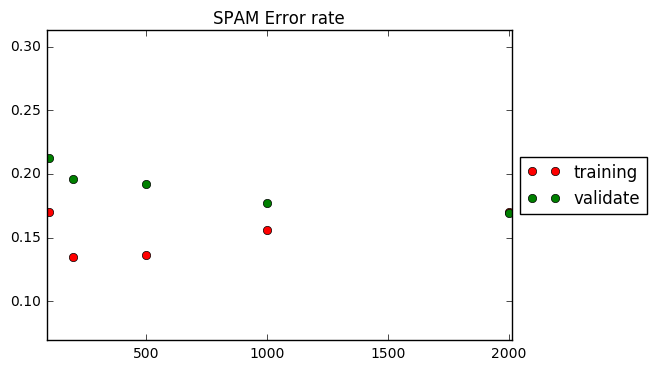

In [6]:
## SPAM
categories = [100, 200, 500, 1000, 2000]
train_and_error(spam_train, spam_validate, categories)

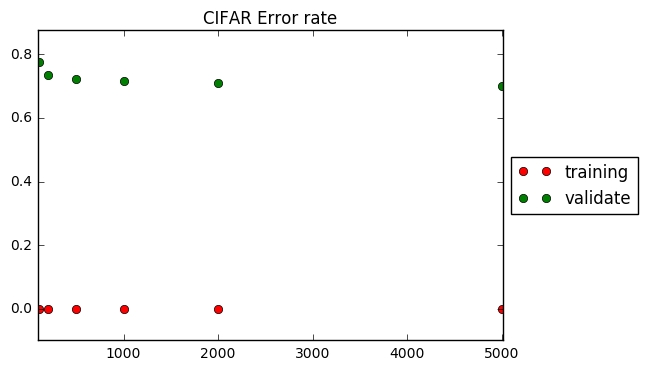

In [12]:
## cifar
categories = [100, 200, 500, 1000, 2000, 5000]
train_and_error(cifar_train, cifar_validate, categories)

# 3. Hyperparameter Tuning

In [11]:
def tune(train_data, validate_data, c_vals):
    train_size = 10000
    errors = []
    x = train_data[:, :-1][:train_size, :]
    y = train_data[:, -1:][:train_size].reshape(1, train_size)[0]
    v_x = validate_data[:, :-1]
    v_y = validate_data[:, -1:].reshape(1, len(v_x))[0]
    
    for c_val in c_vals:
        clf = svm.SVC(kernel = "linear", C = c_val)
        clf.fit(x, y)
        v_y_hat = clf.predict(v_x)
        # Error rate
        err = 1 - metrics.accuracy_score(v_y, v_y_hat)
        errors.append(err)
        print("C: ", c_val, "  error: ", err)
    
#     plt.plot([math.log(x) for x in c_vals], errors, 'ro-')
#     plt.axis([math.log(min(c_vals)) - 0.00001, math.log(max(c_vals)) + 0.00001, min(errors) - 0.001, max(errors) + 0.001])
#     plt.title("Error Rate V.S. C Values")
    
    return errors



In [12]:
# First Round
c = [10**i for i in range(-5, 5)]
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in first round: ", min(errors))

C:  1e-05   error:  0.082
C:  0.0001   error:  0.0871
C:  0.001   error:  0.0871
C:  0.01   error:  0.0871
C:  0.1   error:  0.0871
C:  1   error:  0.0871
C:  10   error:  0.0871
C:  100   error:  0.0871
C:  1000   error:  0.0871
C:  10000   error:  0.0871
Lowest Error Rate in first round:  0.082


In [13]:
# Second Round
c = np.linspace(10**(-6), 10**(-4), 5)
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in second round: ", min(errors))

C:  1e-06   error:  0.0699
C:  2.575e-05   error:  0.0856
C:  5.05e-05   error:  0.0865
C:  7.525e-05   error:  0.0869
C:  0.0001   error:  0.0871
Lowest Error Rate in second round:  0.0699


In [14]:
# Third Round
c = np.linspace(2*10**(-8), 7.5*10**(-5), 5)
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in third round: ", min(errors))

C:  2e-08   error:  0.0942
C:  1.8765e-05   error:  0.0847
C:  3.751e-05   error:  0.0864
C:  5.6255e-05   error:  0.0868
C:  7.5e-05   error:  0.0869
Lowest Error Rate in third round:  0.0847


In [15]:
# Fourth Round
c = np.linspace(2*10**(-7), 1.8*10**(-5), 5)
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in fourth round: ", min(errors))

C:  2e-07   error:  0.0725
C:  4.65e-06   error:  0.0763
C:  9.1e-06   error:  0.0813
C:  1.355e-05   error:  0.0832
C:  1.8e-05   error:  0.0844
Lowest Error Rate in fourth round:  0.0725


In [16]:
# Fifth Round
c = np.linspace(10**(-7), 1.5*10**(-6), 5)
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in fifth round: ", min(errors))

C:  1e-07   error:  0.0762
C:  4.5e-07   error:  0.0727
C:  8e-07   error:  0.0706
C:  1.15e-06   error:  0.0703
C:  1.5e-06   error:  0.0695
Lowest Error Rate in fifth round:  0.0695


In [17]:
# Sixth Round
c = np.linspace(1.15*10**(-6), 1*10**(-6), 5)
errors = tune(mnist_train, mnist_validate, c)
print("Lowest Error Rate in sixth round: ", min(errors))

C:  1.15e-06   error:  0.0703
C:  1.1125e-06   error:  0.0699
C:  1.075e-06   error:  0.0699
C:  1.0375e-06   error:  0.0701
C:  1e-06   error:  0.0699
Lowest Error Rate in sixth round:  0.0699


### * Best C for MNIST:  1.5 x 10^(-6)
### * Kaggle Score: 0.94720

# 4. K-Fold Cross-Validation

In [7]:
def cross_validate(x, y, c_val):
    clf = svm.SVC(kernel='linear', C=c_val)
    scores = cross_val_score(clf, x, y, cv=5)
    accuracy = scores.mean()
    print("C: ", c_val, "  accuracy: ", accuracy)
    
    return accuracy

In [ ]:
spam_train_label = spam_train_label.reshape(1,len(spam_train_label))[0]
# Find best C - first round
c = [10**i for i in range(-5, 2)]
accuracies = []
for val in c:
    acc = cross_validate(spam_train_data, spam_train_label, val)
    accuracies.append(acc)

print("Highest accuracy in first round: ", max(accuracies))

C:  1e-05   accuracy:  0.709976733103
C:  0.0001   accuracy:  0.715777011559
C:  0.001   accuracy:  0.749416832525
C:  0.01   accuracy:  0.776679655015
C:  0.1   accuracy:  0.792725590783
C:  1   accuracy:  0.799106140031
C:  10   accuracy:  0.801040002243
C:  100   accuracy:  0.800846017997


In [8]:
# Find best C - Second round
c = np.linspace(10, 100, 5)
accuracies = []
for val in c:
    acc = cross_validate(spam_train_data, spam_train_label, val)
    accuracies.append(acc)

print("Highest accuracy in second round: ", max(accuracies))

C:  10.0   accuracy:  0.801040002243
C:  32.5   accuracy:  0.80142628879
C:  55.0   accuracy:  0.801039441594
C:  77.5   accuracy:  0.800652594399
C:  100.0   accuracy:  0.800846017997
Highest accuracy in second round:  0.80142628879


In [8]:
spam_train_label = spam_train_label.reshape(1,len(spam_train_label))[0]
# Find best C - first round
c = np.linspace(100, 500, 10)
accuracies = []
for val in c:
    acc = cross_validate(spam_train_data, spam_train_label, val)
    accuracies.append(acc)

print("Highest accuracy in third round: ", max(accuracies))

C:  100.0   accuracy:  0.800846017997
C:  144.444444444   accuracy:  0.800846017997
C:  188.888888889   accuracy:  0.800846017997
C:  233.333333333   accuracy:  0.801232865192
C:  277.777777778   accuracy:  0.801232865192
C:  322.222222222   accuracy:  0.801232865192
C:  366.666666667   accuracy:  0.801232865192
C:  411.111111111   accuracy:  0.801232865192
C:  455.555555556   accuracy:  0.801232865192
C:  500.0   accuracy:  0.801232865192
Highest accuracy in third round:  0.801232865192


In [7]:
# Find best C - Third round
spam_train_label = spam_train_label.reshape(1,len(spam_train_label))[0]
c = np.linspace(10, 55, 5)
accuracies = []
for val in c:
    acc = cross_validate(spam_train_data, spam_train_label, val)
    accuracies.append(acc)

print("Highest accuracy in second round: ", max(accuracies))

C:  10.0   accuracy:  0.801040002243
C:  21.25   accuracy:  0.800846578645
C:  32.5   accuracy:  0.80142628879
C:  43.75   accuracy:  0.80142628879
C:  55.0   accuracy:  0.801039441594
Highest accuracy in second round:  0.80142628879


### Best C for Spam:  200
### Kaggle score: 0.87978

## 5. Kaggle

In [18]:
## Mnist
mnist_test = sio.loadmat("./hw01_data/mnist/test.mat")["testX"]
clf = svm.SVC(kernel="linear", C=1.5*10**(-6))
size = 10000
x = mnist_df[:, :-1]
y = [mnist_df[row][-1] for row in range(0, len(mnist_df))]
clf.fit(x, y)
y_hat = clf.predict(mnist_test)
df = pd.DataFrame(data = y_hat, columns=["Id", "Category"])
df.to_csv("./hw01_data/mnist/prediction.csv")

In [3]:
## Spam
spam_test = sio.loadmat("./hw01_data/spam/spam_data.mat")["test_data"]
clf = svm.SVC(kernel = "linear", C=200)
clf.fit(spam_train_data, spam_train_label)
y_hat = clf.predict(spam_test)
df = pd.DataFrame(data = y_hat)
df.to_csv("./hw01_data/spam/prediction.csv")

/Users/yikaluo/applications/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
